In [1]:
import tensorflow as tf
import torch

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import RandomOverSampler

from kan import *
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import csv

from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuda


In [3]:
# read dataset
df = pd.read_csv("Dataset/bank_marketing/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";")

In [4]:
# preprocessing steps for numerical and categorical data (replace y, replace missing value, encode, scale)
# replace 'yes' with 1 and 'no' with 0
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

target = df['y']
df = df.drop(columns=['y'])

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

features = preprocessor.fit_transform(df)

C:\Users\PC\AppData\Local\Temp\ipykernel_13856\1479273297.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


In [5]:
# split dataset
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

In [6]:
# oversampling
ros = RandomOverSampler(random_state=30)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [7]:
train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val, dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

In [8]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [9]:
torch.cuda.empty_cache()

In [10]:
st = time.time()

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], device=device).to(device)
final_result = model.train(dataset, metrics=(train_acc, test_acc), device=device)

et = time.time()
duration_b4 = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration_b4)

train loss: 2.91e-01 | test loss: 3.27e-01 | reg: 4.61e+01 : 100%|█| 100/100 [11:46<00:00,  7.07s/it

Accuracy 0.8924598693847656 0.8543335795402527
Duration 706.9556086063385


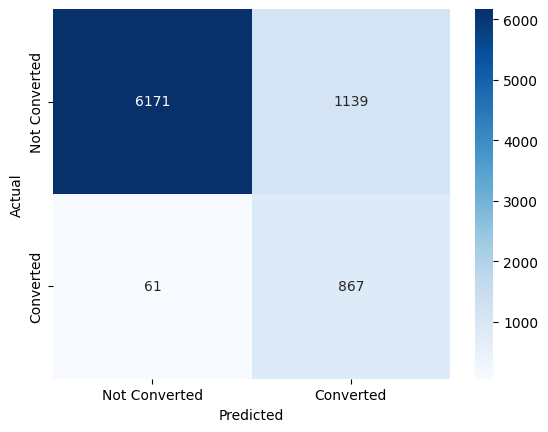

Accuracy: 0.8543335761107065
Precision: 0.4322033898305085
Recall: 0.9342672413793104
F1 Score: 0.591002044989775


In [11]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy_b4 = (tn+tp)/(tn+fp+fn+tp)
precision_b4 = tp / (tp + fp) if (tp + fp) != 0 else 0
recall_b4 = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score_b4 = 2 * (precision_b4 * recall_b4) / (precision_b4 + recall_b4) if (precision_b4 + recall_b4) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy_b4}')
print(f'Precision: {precision_b4}')
print(f'Recall: {recall_b4}')
print(f'F1 Score: {f1_score_b4}')

In [12]:
# fine-tune grid
st = time.time()

grid_values = [1, 3, 5, 7]
results = []

for grid_val in grid_values:
    print(f"\nTraining with grid = {grid_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=grid_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with grid = 1


train loss: 3.12e-01 | test loss: 3.36e-01 | reg: 1.90e+02 : 100%|█| 100/100 [09:51<00:00,  5.91s/it


Train Accuracy: 0.87053245, Test Accuracy: 0.84535080, Duration: 591.34 sec

Training with grid = 3


train loss: 2.89e-01 | test loss: 3.26e-01 | reg: 4.68e+01 : 100%|█| 100/100 [11:50<00:00,  7.11s/it


Train Accuracy: 0.89186728, Test Accuracy: 0.85311967, Duration: 710.92 sec

Training with grid = 5


train loss: 2.82e-01 | test loss: 3.25e-01 | reg: 5.82e+01 : 100%|█| 100/100 [11:25<00:00,  6.85s/it


Train Accuracy: 0.89813548, Test Accuracy: 0.84923524, Duration: 685.27 sec

Training with grid = 7


train loss: 2.78e-01 | test loss: 3.25e-01 | reg: 5.44e+01 : 100%|█| 100/100 [11:17<00:00,  6.77s/it

Train Accuracy: 0.89948034, Test Accuracy: 0.85166299, Duration: 677.19 sec


In [ ]:
# here

In [13]:
# fine-tune k
st = time.time()

k_values = [1, 3, 5, 7]
results = []

for k_val in k_values:
    print(f"\nTraining with k = {k_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=k_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with k = 1


train loss: 2.87e-01 | test loss: 3.30e-01 | reg: 4.41e+01 : 100%|█| 100/100 [09:59<00:00,  6.00s/it


Train Accuracy: 0.89355397, Test Accuracy: 0.85129887, Duration: 599.93 sec

Training with k = 3


train loss: 2.92e-01 | test loss: 3.29e-01 | reg: 4.18e+01 : 100%|█| 100/100 [11:45<00:00,  7.06s/it


Train Accuracy: 0.89077318, Test Accuracy: 0.85069191, Duration: 705.79 sec

Training with k = 5


train loss: 3.09e-01 | test loss: 3.40e-01 | reg: 1.16e+02 : 100%|█| 100/100 [12:02<00:00,  7.22s/it


Train Accuracy: 0.87481767, Test Accuracy: 0.84340858, Duration: 722.28 sec

Training with k = 7


train loss: 2.99e-01 | test loss: 3.37e-01 | reg: 8.93e+01 : 100%|█| 100/100 [14:42<00:00,  8.83s/it

Train Accuracy: 0.88265866, Test Accuracy: 0.83697498, Duration: 882.81 sec


In [14]:
# fine-tune step
st = time.time()

step_values = [25, 50, 75, 100]
results = []

for step_val in step_values:
    print(f"\nTraining with step = {step_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=1, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=step_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with step = 25


train loss: 2.99e-01 | test loss: 3.39e-01 | reg: 3.40e+01 : 100%|██| 25/25 [02:31<00:00,  6.06s/it]


Train Accuracy: 0.88236237, Test Accuracy: 0.84134501, Duration: 151.47 sec

Training with step = 50


train loss: 2.89e-01 | test loss: 3.29e-01 | reg: 4.11e+01 : 100%|██| 50/50 [04:59<00:00,  6.00s/it]


Train Accuracy: 0.89127463, Test Accuracy: 0.83903861, Duration: 299.99 sec

Training with step = 75


train loss: 2.90e-01 | test loss: 3.30e-01 | reg: 4.48e+01 : 100%|██| 75/75 [07:42<00:00,  6.16s/it]


Train Accuracy: 0.89088714, Test Accuracy: 0.84644330, Duration: 462.28 sec

Training with step = 100


train loss: 2.90e-01 | test loss: 3.33e-01 | reg: 4.38e+01 : 100%|█| 100/100 [10:10<00:00,  6.10s/it

Train Accuracy: 0.89075035, Test Accuracy: 0.83806747, Duration: 610.06 sec


In [15]:
# fine-tune lamb
st = time.time()

lamb_values = [0, 0.1, 0.01, 0.001]
results = []

for lamb_val in lamb_values:
    print(f"\nTraining with lamb = {lamb_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=1, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=75, lamb=lamb_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with lamb = 0


train loss: 2.93e-01 | test loss: 3.35e-01 | reg: 4.16e+01 : 100%|██| 75/75 [07:38<00:00,  6.12s/it]


Train Accuracy: 0.88673872, Test Accuracy: 0.84717166, Duration: 458.89 sec

Training with lamb = 0.1


train loss: 4.19e-01 | test loss: 4.19e-01 | reg: 1.14e+01 : 100%|██| 75/75 [06:10<00:00,  4.94s/it]


Train Accuracy: 0.76048505, Test Accuracy: 0.79679531, Duration: 370.86 sec

Training with lamb = 0.01


train loss: 3.42e-01 | test loss: 3.40e-01 | reg: 1.19e+01 : 100%|██| 75/75 [07:22<00:00,  5.91s/it]


Train Accuracy: 0.84796685, Test Accuracy: 0.84984219, Duration: 442.99 sec

Training with lamb = 0.001


train loss: 3.02e-01 | test loss: 3.41e-01 | reg: 1.21e+01 : 100%|██| 75/75 [07:07<00:00,  5.69s/it]

Train Accuracy: 0.88033372, Test Accuracy: 0.84195191, Duration: 427.09 sec


In [16]:
# fine-tune lamb entropy
st = time.time()

lamb_ent_values = [0, 0.1, 0.01, 0.001]
results = []

for lamb_ent_val in lamb_ent_values:
    print(f"\nTraining with lamb entropy = {lamb_ent_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=1, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=75, lamb=0.01, lamb_entropy=lamb_ent_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with lamb entropy = 0


train loss: 3.08e-01 | test loss: 3.42e-01 | reg: 8.12e-01 : 100%|██| 75/75 [06:53<00:00,  5.52s/it]


Train Accuracy: 0.88106310, Test Accuracy: 0.83818889, Duration: 414.00 sec

Training with lamb entropy = 0.1


train loss: 3.13e-01 | test loss: 3.37e-01 | reg: 1.55e+00 : 100%|██| 75/75 [06:42<00:00,  5.36s/it]


Train Accuracy: 0.87456691, Test Accuracy: 0.84741443, Duration: 402.26 sec

Training with lamb entropy = 0.01


train loss: 3.08e-01 | test loss: 3.41e-01 | reg: 9.62e-01 : 100%|██| 75/75 [06:56<00:00,  5.55s/it]


Train Accuracy: 0.88044769, Test Accuracy: 0.83855307, Duration: 416.22 sec

Training with lamb entropy = 0.001


train loss: 3.09e-01 | test loss: 3.39e-01 | reg: 7.98e-01 : 100%|██| 75/75 [06:59<00:00,  5.59s/it]

Train Accuracy: 0.87857860, Test Accuracy: 0.84183055, Duration: 419.12 sec


train loss: 3.11e-01 | test loss: 3.37e-01 | reg: 1.54e+00 : 100%|██| 75/75 [06:18<00:00,  5.05s/it]


Accuracy 0.8765955567359924 0.8464432954788208
Duration 378.468567609787


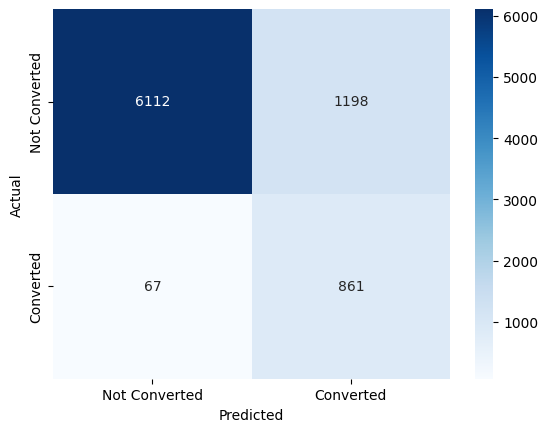

Accuracy: 0.8464433114833697
Precision: 0.41816415735794077
Recall: 0.927801724137931
F1 Score: 0.5764981586876464


In [17]:
# after fine-tune
st = time.time()

best_model = {'grid': 3, 'k': 1, 'step': 75, 'lamb': 0.01, 'lamb_entropy': 0.1}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()
duration = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration)

# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

In [18]:
# save to csv
filename = "30.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Before", "After"])
    writer.writerow(["Accuracy", accuracy_b4, accuracy])
    writer.writerow(["Precision", precision_b4, precision])
    writer.writerow(["Recall", recall_b4, recall])
    writer.writerow(["F1 Score", f1_score_b4, f1_score])
    writer.writerow(["Duration", duration_b4, duration])